# Proyek Klasifikasi Gambar: [Intel Image Classification]
- **Nama:** [MUHAMMAD AGUSRIANSYAH]
- **Email:** [mc224d5y1338@student.devacademy.id]
- **ID Dicoding:** [MC224D5Y1338]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Import library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
import pathlib
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## Data Preparation

### Data Loading

In [2]:
# Unduh dataset dari KaggleHub
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")

# Path ke folder 'seg_train/seg_train'
data_dir = pathlib.Path(dataset_path) / "seg_train" / "seg_train"

# Isi folder kelas
print("Isi folder kelas di seg_train:", os.listdir(data_dir))

Isi folder kelas di seg_train: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


<ipython-input-3-7a37e1f45367>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=distribution_train, x='labels', palette='Set2')


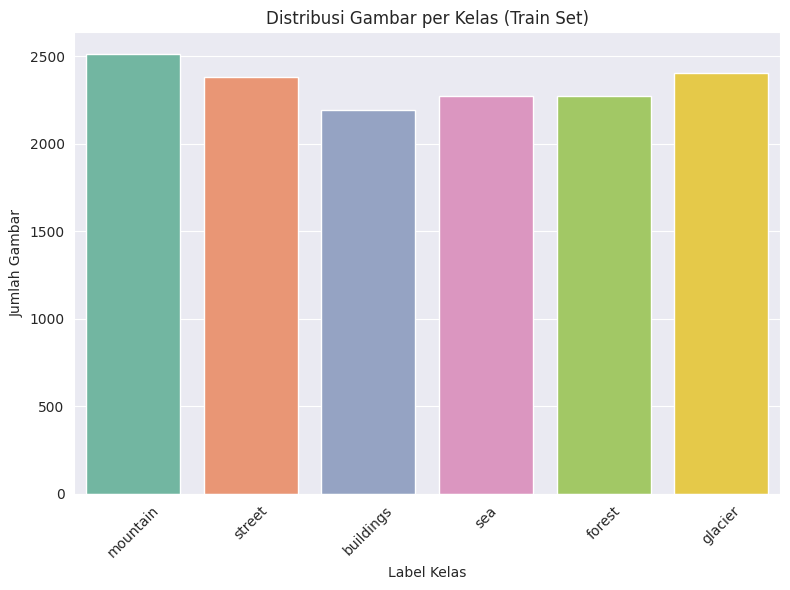

In [3]:
# Path untuk eksplorasi file
intel_path = os.path.join(dataset_path, "seg_train", "seg_train")

# List untuk menyimpan data
file_name = []
labels = []
full_path = []

# Seluruh file gambar dan informasi
for path, _, files in os.walk(intel_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):  # hanya file gambar
            file_path = os.path.join(path, name)
            full_path.append(file_path)
            labels.append(os.path.basename(path))  # nama folder = label
            file_name.append(name)

# Buat DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi kelas
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_train, x='labels', palette='Set2')
plt.title("Distribusi Gambar per Kelas (Train Set)")
plt.xlabel("Label Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [4]:
# Setting parameter dasar
batch_size = 32
seed = 123

In [5]:
img_height, img_width = 224, 224

In [6]:
# Membuat train dataset (70%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 30% dibagi untuk validasi dan test
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.
Using 9824 files for training.


In [7]:
# Class names dari salah satu subset
class_names = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
).class_names

Found 14034 files belonging to 6 classes.
Using 4210 files for validation.


In [8]:
# Membuat validation dataset (30%)
val_ds_full = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.
Using 4210 files for validation.


In [9]:
# Bagi val_ds_full menjadi val_ds dan test_ds
val_batches = tf.data.experimental.cardinality(val_ds_full)
test_ds = val_ds_full.take(val_batches // 2)
val_ds = val_ds_full.skip(val_batches // 2)

In [10]:
# Menampilkan jumlah batch
print(f"Jumlah batch di training set: {tf.data.experimental.cardinality(train_ds)}")
print(f"Jumlah batch di validation set: {tf.data.experimental.cardinality(val_ds)}")
print(f"Jumlah batch di test set: {tf.data.experimental.cardinality(test_ds)}")

Jumlah batch di training set: 307
Jumlah batch di validation set: 66
Jumlah batch di test set: 66


In [11]:
# Augmentasi untuk train_ds
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
])

# Normalisasi
normalization_layer = layers.Rescaling(1./255)

# Augmentasi ke dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


## Modelling

In [12]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(img_height, img_width, 3))
x = normalization_layer(inputs)  # normalisasi lagi
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7168 - loss: 0.7490

307/307 ━━━━━━━━━━━━━━━━━━━━ 194s 596ms/step - accuracy: 0.7170 - loss: 0.7484 - val_accuracy: 0.8961 - val_loss: 0.2997
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8491 - loss: 0.4121

307/307 ━━━━━━━━━━━━━━━━━━━━ 164s 535ms/step - accuracy: 0.8491 - loss: 0.4121 - val_accuracy: 0.8894 - val_loss: 0.2973
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8526 - loss: 0.3992

307/307 ━━━━━━━━━━━━━━━━━━━━ 203s 539ms/step - accuracy: 0.8526 - loss: 0.3992 - val_accuracy: 0.8999 - val_loss: 0.2742
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8708 - loss: 0.3691

307/307 ━━━━━━━━━━━━━━━━━━━━ 201s 535ms/step - accuracy: 0.8708 - loss: 0.3691 - val_accuracy: 0.9051 - val_loss: 0.2663
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8751 - loss: 0.3697

307/307 ━━━━━━━━━━━━━━━━━━━━ 201s 534ms/step - accuracy: 0.8751 - loss: 0.3697 - val_accuracy: 0.9071 - val_loss: 0.2608
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8706 - loss: 0.3550

307/307 ━━━━━━━━━━━━━━━━━━━━ 203s 536ms/step - accuracy: 0.8706 - loss: 0.3550 - val_accuracy: 0.9080 - val_loss: 0.2594
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 165s 536ms/step - accuracy: 0.8693 - loss: 0.3444 - val_accuracy: 0.9075 - val_loss: 0.2648
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8787 - loss: 0.3401

307/307 ━━━━━━━━━━━━━━━━━━━━ 202s 536ms/step - accuracy: 0.8787 - loss: 0.3400 - val_accuracy: 0.9118 - val_loss: 0.2524
Epoch 9/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8723 - loss: 0.3397

307/307 ━━━━━━━━━━━━━━━━━━━━ 202s 537ms/step - accuracy: 0.8723 - loss: 0.3397 - val_accuracy: 0.9056 - val_loss: 0.2519
Epoch 10/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 164s 534ms/step - accuracy: 0.8794 - loss: 0.3219 - val_accuracy: 0.9032 - val_loss: 0.2545


In [14]:
# Buka sebagian besar layer
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile ulang dengan LR kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning training
fine_tune_epochs = 20
total_epochs = history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 10/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 209s 572ms/step - accuracy: 0.7221 - loss: 0.7777 - val_accuracy: 0.8875 - val_loss: 0.3235 - learning_rate: 1.0000e-05
Epoch 11/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 559ms/step - accuracy: 0.8213 - loss: 0.4742 - val_accuracy: 0.9085 - val_loss: 0.2912 - learning_rate: 1.0000e-05
Epoch 12/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 201s 557ms/step - accuracy: 0.8571 - loss: 0.3946 - val_accuracy: 0.9085 - val_loss: 0.2823 - learning_rate: 1.0000e-05
Epoch 13/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 204s 564ms/step - accuracy: 0.8678 - loss: 0.3654 - val_accuracy: 0.9180 - val_loss: 0.2546 - learning_rate: 1.0000e-05
Epoch 14/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 200s 559ms/step - accuracy: 0.8813 - loss: 0.3466 - val_accuracy: 0.9147 - val_loss: 0.2607 - learning_rate: 1.0000e-05
Epoch 15/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.8875 - loss: 0.3291

307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 561ms/step - accuracy: 0.8875 - loss: 0.3291 - val_accuracy: 0.9190 - val_loss: 0.2431 - learning_rate: 1.0000e-05
Epoch 16/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 172s 560ms/step - accuracy: 0.8933 - loss: 0.2985 - val_accuracy: 0.9180 - val_loss: 0.2482 - learning_rate: 1.0000e-05
Epoch 17/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 204s 566ms/step - accuracy: 0.9025 - loss: 0.2834 - val_accuracy: 0.9171 - val_loss: 0.2456 - learning_rate: 1.0000e-05
Epoch 18/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9027 - loss: 0.2748

307/307 ━━━━━━━━━━━━━━━━━━━━ 174s 564ms/step - accuracy: 0.9027 - loss: 0.2748 - val_accuracy: 0.9180 - val_loss: 0.2371 - learning_rate: 2.0000e-06
Epoch 19/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 199s 556ms/step - accuracy: 0.8995 - loss: 0.2807 - val_accuracy: 0.9161 - val_loss: 0.2432 - learning_rate: 2.0000e-06
Epoch 20/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 556ms/step - accuracy: 0.9074 - loss: 0.2666 - val_accuracy: 0.9133 - val_loss: 0.2415 - learning_rate: 2.0000e-06
Epoch 21/29
307/307 ━━━━━━━━━━━━━━━━━━━━ 202s 555ms/step - accuracy: 0.9049 - loss: 0.2707 - val_accuracy: 0.9152 - val_loss: 0.2404 - learning_rate: 4.0000e-07


### Plot Akurasi & Loss

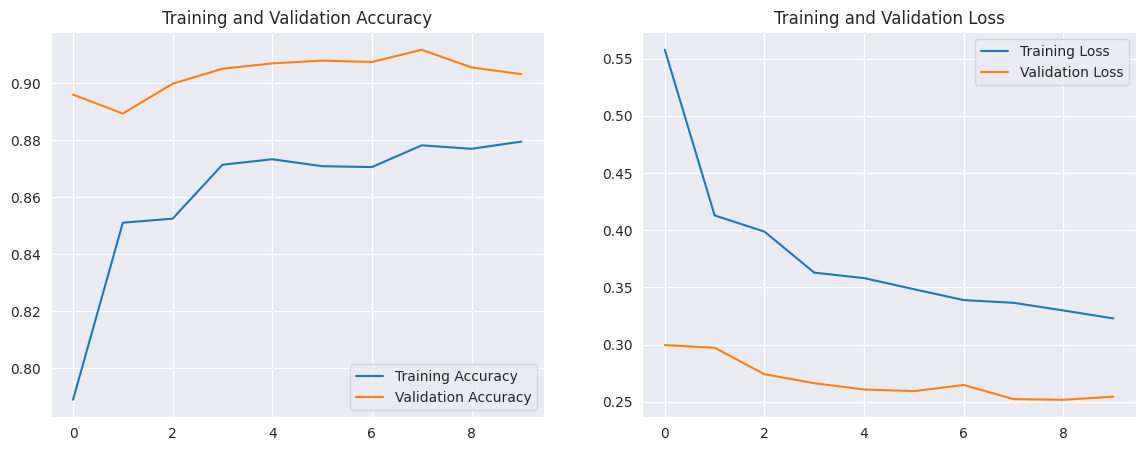

In [15]:
# Fungsi plot
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Panggil fungsi plot
plot_training(history)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9163 - loss: 0.2456

Test Accuracy: 0.91
Test Loss: 0.23
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━

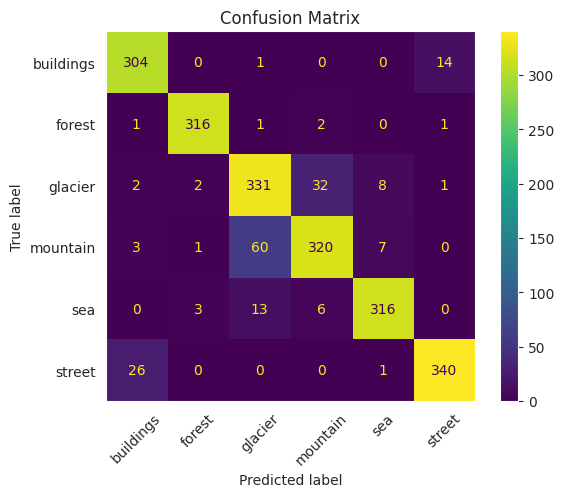


Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.95      0.93       319
      forest       0.98      0.98      0.98       321
     glacier       0.82      0.88      0.85       376
    mountain       0.89      0.82      0.85       391
         sea       0.95      0.93      0.94       338
      street       0.96      0.93      0.94       367

    accuracy                           0.91      2112
   macro avg       0.92      0.92      0.92      2112
weighted avg       0.91      0.91      0.91      2112



In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Prediksi label
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Evaluasi dan Visualisasi

In [17]:
# Evaluasi model menggunakan test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f'\nTest Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9148 - loss: 0.2497

Test Accuracy: 91.15%
Test Loss: 0.2392


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


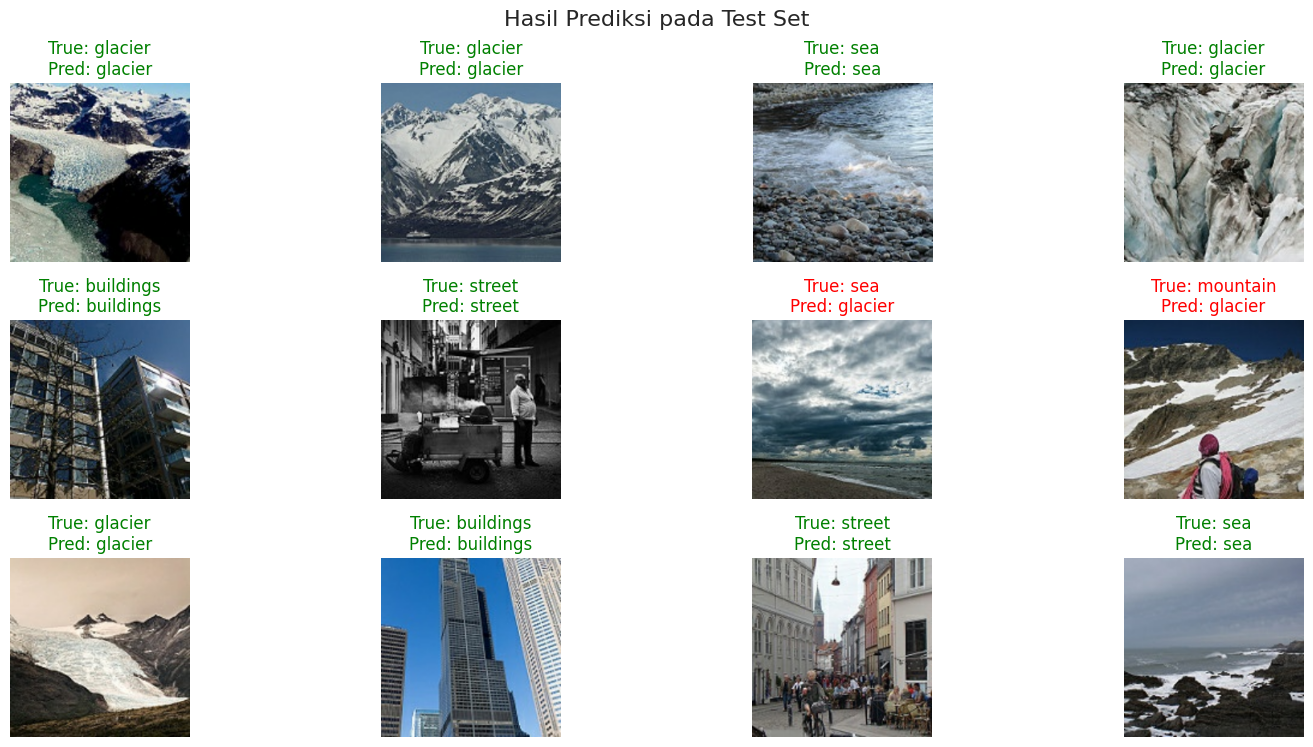

In [18]:
# Ambil 1 batch dari test_ds
plt.figure(figsize=(15, 10))
for images, labels in test_ds.take(1):
    # Prediksi
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Tampilkan gambar
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]

        color = "green" if predicted_labels[i] == labels[i] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")

plt.suptitle("Hasil Prediksi pada Test Set", fontsize=16)
plt.tight_layout()
plt.show()


## Konversi Model

### SavedModel

In [25]:
model.export('saved_model_format')  # simpan sebagai SavedModel
!zip -r saved_model_format.zip saved_model_format  # kompres folder
from google.colab import files
files.download("saved_model_format.zip")  # download zip

Saved artifact at 'saved_model_format'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140127039676368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140126987738320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140126987738512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140127039676944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140127039676752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140126987739472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140126987740816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140126987741200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140126987741008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140126987739664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012698

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TF Lite

In [26]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_format")
tflite_model = converter.convert()

# Simpan ke file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Download TFLite
files.download("model.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TensorFlow.js

In [23]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [27]:
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model_format tfjs_model

# Kompres dan download
!zip -r tfjs_model.zip tfjs_model
files.download("tfjs_model.zip")

2025-04-30 16:49:23.748220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746031763.768332   22466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746031763.775704   22466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-30 16:49:27.893651: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746031767.893811   22466 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

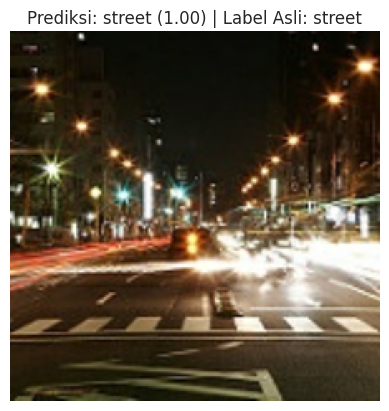

In [34]:
# Load inference layer
inference_layer = TFSMLayer("saved_model_format", call_endpoint="serving_default")

# Ambil satu gambar dari dataset
for images, labels in val_ds.take(1):
    test_img = images[0]
    true_label = labels[0].numpy()

# Inference
input_img = tf.expand_dims(test_img, axis=0)
raw_output = inference_layer(input_img)
pred = list(raw_output.values())[0].numpy()

# Ambil prediksi
predicted_index = np.argmax(pred)
predicted_class = class_names[predicted_index]
confidence = np.max(pred)

# Tampilkan
plt.imshow(test_img.numpy() / 255.0)
plt.title(f"Prediksi: {predicted_class} ({confidence:.2f}) | Label Asli: {class_names[true_label]}")
plt.axis('off')
plt.show()